In [1]:
import pandas as pd
import numpy as np
import implicit

Implicit - неявный таргет. Это действия, которые не говорят явно о том, как пользователь оценил объект: клики, просмотры и тд. Таких данных гораздо больше в системе.
Обычно стараются использовать как можно больше данных, взвешивая разный тип таргета.

In [4]:
import scipy

библиотека основанная на расширении NumPy, но для более глубоких и сложных научных вычислений, анализа данных и построения графиков. SciPy в основном написана на Python и частично на языках C, C++ и Fortran, поэтому отличается высокой производительностью и скоростью работы.

SciPy используют:
- для сложных математических расчетов, которые тяжело произвести вручную или с помощью калькулятора;
- проведения научных исследований, где требуется использование продвинутой математики;
- глубокого анализа данных, интерполяции и других методов работы с информацией;
- машинного обучения и создания моделей искусственного интеллекта, прогнозирования и построения моделей;
- формирования двумерных и трехмерных графиков, которые можно потом визуализировать (уже при помощи других библиотек).

Основные различия между SciPy и NumPy:
- в SciPy гораздо больше функций и методов, чем в NumPy;
- NumPy ориентирована на базовые вычисления и простую работу с матрицами, SciPy предназначена для глубокого научного анализа;
- NumPy не имеет дополнительных зависимостей, вместе с библиотекой не нужно ничего устанавливать. SciPy требует установки NumPy для корректной работы.

*SciPy расширяет возможности NumPy, а некоторые частые действия в ней реализованы как отдельные функции, поэтому библиотека сильно упрощает работу со сложными задачами с использованием продвинутой математики.*

При этом для ряда более простых задач она избыточна. Будет достаточно NumPy или других библиотек. 

In [7]:
import catboost
from implicit.evaluation import ndcg_at_k, mean_average_precision_at_k, precision_at_k
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [9]:
import rectools

библиотека, которая собрала в себе все самые необходимые модели, метрики и инструменты для построения рекомендательных систем. Туда также внедрены методы ускорения работы рекомендаций, многие модели поддерживают GPU.

In [12]:
from implicit.nearest_neighbours import TFIDFRecommender, BM25Recommender
from implicit.als import AlternatingLeastSquares

from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import Precision, Recall, MeanInvUserFreq, Serendipity, MAP, calc_metrics, MeanInvUserFreq
from rectools.models import ImplicitItemKNNWrapperModel, RandomModel, PopularModel, ImplicitALSWrapperModel, EASEModel
from rectools.model_selection import TimeRangeSplitter, cross_validate

In [14]:
data = pd.read_csv('recs.csv')

In [16]:
data.head()

,sale_date,user_id,Gender,Age,R,F,M,item_id,Qty,Amount,Product_Name,Product_Line_1,Color,Discount,Base_Price
0,2023-04-08,452030256342,U,52.0,1,1,2,147003,1.0,1230.0,Паддл Крик Рислинг Розе,ВИНО,РОЗОВОЕ,0.0,1640.0
1,2022-01-11,722758534602,U,0.0,0,0,0,147367,12.0,4020.0,Альма Романа Пино Гриджо,ВИНО,БЕЛОЕ,0.0,370.0
2,2022-07-25,416284110335,Ж,0.0,2,5,5,146069,2.0,2616.0,Просекко Супериоре Вальдоббьяд,ШАМПАНСКОЕ,БЕЛОЕ,0.0,1640.0
3,2022-11-02,846586656243,U,0.0,0,0,0,118402,6.0,8755.5,Ле Риме (Тоскана) в п/у,ВИНО,БЕЛОЕ,4714.5,1780.0
4,2022-02-13,228487079590,U,0.0,3,2,4,144236,1.0,1549.0,Божоле-Вилляж,ВИНО,КРАСНОЕ,0.0,1740.0


In [18]:
interactions = data[['sale_date', 'user_id', 'item_id', 'Qty']]

In [20]:
interactions.sort_values(by='sale_date', inplace=True)

/var/folders/lc/5rfqsc9n76lgbbm57374y8p00000gn/T/ipykernel_98345/1579602194.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions.sort_values(by='sale_date', inplace=True)


In [22]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2936535 entries, 2309021 to 2607094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   sale_date  object 
 1   user_id    int64  
 2   item_id    int64  
 3   Qty        float64
dtypes: float64(1), int64(2), object(1)
memory usage: 112.0+ MB


In [24]:
interactions.sale_date = pd.to_datetime(interactions.sale_date)

/var/folders/lc/5rfqsc9n76lgbbm57374y8p00000gn/T/ipykernel_98345/3471329340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions.sale_date = pd.to_datetime(interactions.sale_date)


In [26]:
# Train/test

In [28]:
max_date = interactions['sale_date'].max()
min_date = interactions['sale_date'].min()

print(f"min дата в interactions: {min_date}")
print(f"max дата в interactions: {max_date}")

min дата в interactions: 2022-01-01 00:00:00
max дата в interactions: 2024-03-27 00:00:00


In [30]:
train = interactions[(interactions['sale_date'] < max_date - pd.Timedelta(days=120))]
test = interactions[(interactions['sale_date'] >= max_date - pd.Timedelta(days=120))]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (2376623, 4)
test: (559912, 4)


In [32]:
train.head()

,sale_date,user_id,item_id,Qty
2309021,2022-01-01,791652193564,138415,1.0
2521819,2022-01-01,914509930443,147061,1.0
1315784,2022-01-01,663944080364,138421,1.0
688323,2022-01-01,114605570770,138416,2.0
367133,2022-01-01,262499958887,135283,1.0


In [34]:
client_mapping = {client_id: i for i, client_id in enumerate(train['user_id'].unique())}
inverse_client_mapping = {i: client_id for client_id, i in client_mapping.items()}

sku_mapping = {sku: i for i, sku in enumerate(train['item_id'].unique())} #уникальные товарные идентификаторы
inverse_sku_mapping = {i: sku for sku, i in sku_mapping.items()}

In [36]:
users = np.array(train['user_id'].map(client_mapping))
items = np.array(train['item_id'].map(sku_mapping))
ratings = np.array(train['Qty']) #количество

In [38]:
user_item_matrix = scipy.sparse.csr_matrix((ratings, (users, items)))

Разреженные матрицы можно использовать в арифметических операциях: они поддерживают сложение, вычитание, умножение, деление и возведение матриц в степень.

In [41]:
als = implicit.als.AlternatingLeastSquares(factors = 10, \
      iterations = 10, use_gpu = False, calculate_training_loss = False, regularization = 0.1)

/opt/anaconda3/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 10 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


Альтернативный метод наименьших квадратов. Реализация рекомендателя с использованием метода альтернативных наименьших квадратов для факторизации матрицы в совместной фильтрации. В совместной фильтрации факторизация матрицы является передовым решением для проблем с разреженными данными, часто встречающихся при работе с входными данными рекомендательных систем.

In [44]:
als.fit(user_item_matrix)

  0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
train.head()

,sale_date,user_id,item_id,Qty
2309021,2022-01-01,791652193564,138415,1.0
2521819,2022-01-01,914509930443,147061,1.0
1315784,2022-01-01,663944080364,138421,1.0
688323,2022-01-01,114605570770,138416,2.0
367133,2022-01-01,262499958887,135283,1.0


In [48]:
als.recommend(client_mapping[791652193564],
              N=10, user_items=user_item_matrix, 
              filter_already_liked_items=False)

(array([   0,   23,    8,    3,  474,  115,   85,    2, 4565,   82],
       dtype=int32),
 array([0.3474276 , 0.26245776, 0.2234195 , 0.19125447, 0.16356231,
        0.14032839, 0.13747397, 0.12625659, 0.12492196, 0.10392302],
       dtype=float32))

Рекомендует товары для пользователей.

Этот метод позволяет вычислить лучшие N рекомендаций для пользователя или группы пользователей. Передача массива идентификаторов пользователей вместо одного идентификатора пользователя, как правило, более эффективна и допускает многопоточную обработку на ЦП.

Этот метод имеет параметры для фильтрации элементов из результатов. Вы можете отфильтровать элементы, которые уже понравились пользователю, с помощью параметра filter_already_liked_items, а также передать filter_items, чтобы отфильтровать другие элементы для всех пользователей в пакете. По умолчанию все элементы в обучающем наборе данных оцениваются, но, установив параметр 'items', вы можете ограничиться подмножеством.

In [51]:
# rectools

In [53]:
interactions.rename(columns={'sale_date':Columns.Datetime, 'Qty':Columns.Weight}, inplace=True)

/var/folders/lc/5rfqsc9n76lgbbm57374y8p00000gn/T/ipykernel_98345/573105263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions.rename(columns={'sale_date':Columns.Datetime, 'Qty':Columns.Weight}, inplace=True)


In [55]:
%%time
dataset = Dataset.construct(interactions_df=interactions)

CPU times: user 114 ms, sys: 47.3 ms, total: 162 ms
Wall time: 162 ms


In [242]:
# Take few simple models to compare
models = {
    "random": RandomModel(random_state=42),
    "popular": PopularModel(),
    "most_raited": PopularModel(popularity="sum_weight"),
    "tfidf_k=5": ImplicitItemKNNWrapperModel(model=TFIDFRecommender(K=5)), #Обертка для implicit.nearest_neighbours.ItemItemRecommender и его последователей.
    "tfidf_k=10": ImplicitItemKNNWrapperModel(model=TFIDFRecommender(K=10)),
    "bm25_k=10_k1=0.05_b=0.1": ImplicitItemKNNWrapperModel(model=BM25Recommender(K=5, K1=0.05, B=0.1)),
    "als" : ImplicitALSWrapperModel(AlternatingLeastSquares(factors = 10, iterations = 10, use_gpu = False, calculate_training_loss = False, regularization = 0.1)),
    "ease" : EASEModel()
}

# We will calculate several classic (precision@k and recall@k) and "beyond accuracy" metrics
metrics = {
    "prec@1": Precision(k=1),
    "prec@10": Precision(k=10),
    "recall@1": Recall(k=10),
    "recall@10": Recall(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10)
}

K_RECS = 10

ImplicitItemKNNWrapperModel
Параметры
- модель ( ItemItemRecommender ) – базовая модель, которая будет использоваться.
- verbose ( int , default 0 ) – Степень подробного вывода. Если 0, вывод не будет предоставлен.

TFIDFRecommender - Рекомендатель элементов по расстояниям TF-IDF между элементами
Параметры
- K ( int , необязательно ) – количество соседей, включаемых при расчете матрицы сходства элементов
- num_threads ( int , необязательно ) – Количество потоков, используемых для подгонки модели. Указание 0 означает использование по умолчанию количества ядер на машине.

BM25Recommender - Рекомендатель элементов по расстоянию BM25 между элементами

ImplicitALSWrapperModel - Обертка для implicit.als.AlternatingLeastSquares с возможностью использования явных функций и поддержкой GPU.
Параметры
- модель ( AnyAlternatingLeastSquares ) – базовая модель, которая будет использоваться.
- fit_features_together ( bool , по умолчанию False ) – Подходят ли явные признаки вместе со скрытыми признаками или нет. Используется только в том случае, если в наборе данных присутствуют явные признаки. Подробности см. в документации, ссылки на которую приведены выше.
- recommend_n_threads (Необязательно[int], default None) – Количество потоков для использования при ранжировании рекомендаций на ЦП. Указание 0означает, что по умолчанию будет использоваться количество ядер на машине. Если None, то количество потоков будет установлено таким же, как model.num_threads . Если вы хотите изменить этот параметр после инициализации модели, вы можете вручную назначить новое значение атрибуту model recommend_n_threads.
- recommend_use_gpu_ranking (Необязательный[bool], по умолчанию None) – Флаг использования GPU для ранжирования рекомендаций. Если None, то будет установлено то же, что и model.use_gpu . implicit.gpu.HAS_CUDA также будет проверено перед выводом. Обратите внимание, что ранжирование GPU и CPU может обеспечивать разный порядок элементов с одинаковыми оценками в таблице рекомендаций. Если вы хотите изменить этот параметр после инициализации модели, вы можете вручную назначить новое значение атрибуту recommend_use_gpu_ranking модели .
- verbose ( int , default 0 ) – Степень подробного вывода. Если 0, вывод не будет предоставлен.

In [60]:
n_splits = 3

splitter = TimeRangeSplitter(
    test_size="7D",
    n_splits=n_splits,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)

Разделитель для перекрестной проверки по схеме «оставить-тайм-аут». Генерация обучающего и тестового набора, помещающего все взаимодействия для всех пользователей после фиксированной даты-времени в тест и все взаимодействия до этой даты-времени в обучающий набор. Перекрестная проверка достигается с помощью скользящего окна по временной шкале взаимодействий.

Размер окна определяется в днях или часах. Тестовые складки не пересекаются и начинаются одна за другой. Эта методика полностью воспроизводит реальный сценарий для рекомендательных систем, предотвращая утечку данных из будущего.

Рекомендуется запоминать ежедневные и недельные закономерности во временных рядах, делая каждую складку равной полному дню или полной неделе, если такие закономерности присутствуют в данных.

Также можно исключить холодных пользователей и предметы, а также уже просмотренные предметы.

Параметры
- test_size ( str ) – Размер тестовой складки в формате [1-9]\d*[DH], например 1D(1 день), 4H(4 часа). Тестовые складки берутся с конца взаимодействий . Последняя складка включает в себя всю единицу времени с последним взаимодействием. Например, если последнее взаимодействие было в 01:25 утра понедельника, то при test_size = «1D» последняя складка будет полным понедельником, а при test_size = «1H» последняя складка будет между 01:00 и 02:00 утра понедельника.
- n_splits ( int ) – Количество тестовых складок.
- filter_cold_users (bool, default True) – Если True , пользователи, которые не присутствуют в train, будут исключены из теста. ВНИМАНИЕ: как холодные, так и теплые пользователи будут исключены из теста.
- filter_cold_items (bool, default True) – Если True , элементы, отсутствующие в train, будут исключены из теста. ВНИМАНИЕ: как холодные, так и теплые элементы будут исключены из теста.
- filter_already_seen (bool, default True) – если True, то пары (пользователь, элемент), присутствующие в поезде, будут исключены из теста.

In [63]:
%%time

# For each fold generate train and test part of dataset
# Then fit every model, generate recommendations and calculate metrics

cv_results = cross_validate(
    dataset=dataset,
    splitter=splitter,
    models=models,
    metrics=metrics,
    k=K_RECS,
    filter_viewed=True,
)

CPU times: user 3min 32s, sys: 15.2 s, total: 3min 47s
Wall time: 1min 27s


In [65]:
pivot_results = (
    pd.DataFrame(cv_results["metrics"])
    .drop(columns="i_split")
    .groupby(["model"], sort=False)
    .agg(["mean", "std"])
)
mean_metric_subset = [(metric, "mean") for metric in pivot_results.columns.levels[0]]
(
    pivot_results.style
    .highlight_min(subset=mean_metric_subset, color='lightcoral', axis=0)
    .highlight_max(subset=mean_metric_subset, color='lightgreen', axis=0)
)

In [67]:
random_model = RandomModel(random_state=42)

In [69]:
random_model.fit(dataset)

In [71]:
tfidf = ImplicitItemKNNWrapperModel(model=TFIDFRecommender(K=5))

In [73]:
tfidf.fit(dataset)

In [75]:
bm_model = ImplicitItemKNNWrapperModel(model=BM25Recommender(K=5, K1=0.05, B=0.1))

In [77]:
bm_model.fit(dataset)

In [79]:
#test

In [81]:
test = test[test.user_id.isin(train.user_id.unique())]

In [83]:
random_test_recos = random_model.recommend(
    users=test.user_id.unique(),
    dataset=dataset,
    k=150,
    filter_viewed=True
)

In [118]:
random_test_recos

,user_id,item_id,score,rank
0,260171391439,128185,150.0,1
1,260171391439,138325,149.0,2
2,260171391439,145445,148.0,3
3,260171391439,147478,147.0,4
4,260171391439,143497,146.0,5
...,...,...,...,...
12378895,398159299203,132160,5.0,146
12378896,398159299203,147934,4.0,147
12378897,398159299203,146706,3.0,148
12378898,398159299203,135305,2.0,149


In [85]:
tfidf_test_recos = tfidf.recommend(
    users=test.user_id.unique(),
    dataset=dataset,
    k=150,
    filter_viewed=True
)

In [120]:
tfidf_test_recos

,user_id,item_id,score,rank
0,260171391439,146939,44.074337,1
1,260171391439,142561,43.559376,2
2,260171391439,144426,41.756111,3
3,260171391439,144429,31.790468,4
4,260171391439,144553,31.012880,5
...,...,...,...,...
3287080,398159299203,137079,0.574738,8
3287081,398159299203,142259,0.572844,9
3287082,398159299203,138254,0.571737,10
3287083,398159299203,144900,0.478234,11


In [87]:
bm_test_recos = bm_model.recommend(
    users=test.user_id.unique(),
    dataset=dataset,
    k=150,
    filter_viewed=True
)

In [252]:
metrics_name = {
    'MAP': MAP,
    'Precision': Precision,
    'Recall' : Recall,
    'MIUF': MeanInvUserFreq
    

}
metrics = {}
for metric_name, metric in metrics_name.items():
    for k in (1, 5, 10):
        metrics[f'{metric_name}@{k}'] = metric(k=k)

In [180]:
two_recos = random_test_recos.merge(right=tfidf_test_recos, on = ['user_id', 'item_id'], how='inner', suffixes=['_random', '_tfidf'])
#how - как именно объединять между собой датафреймы
#можно использовать left, что отдает приоритет только колонкам левого (рандомтест) массива. 
#Тут нужен inner, который сохраняет значения между пересекающимися по названию колонками

In [182]:
two_recos

,user_id,item_id,score_random,rank_random,score_tfidf,rank_tfidf
0,260171391439,141127,68.0,83,1.487678,36
1,145633236770,147488,90.0,61,50.593842,13
2,145633236770,145759,63.0,88,37.175980,16
3,145633236770,139903,55.0,96,7.108153,67
4,145633236770,105440,3.0,148,2.593013,123
...,...,...,...,...,...,...
86682,817726664291,126604,2.0,149,0.231237,47
86683,577331409839,135647,74.0,77,216.295120,1
86684,562666272606,142818,112.0,39,0.339521,19
86685,562666272606,147490,57.0,94,1.540246,1


In [202]:
three_recos = two_recos.merge(bm_test_recos, on = ['user_id', 'item_id'], how='left')
three_recos = three_recos.rename(columns={'rank':'rank_bm', 'score':'score_bm'})

In [204]:
three_recos

,user_id,item_id,score_random,rank_random,score_tfidf,rank_tfidf,score_bm,rank_bm
0,260171391439,141127,68.0,83,1.487678,36,1.017680e+05,10.0
1,145633236770,147488,90.0,61,50.593842,13,NaN,NaN
2,145633236770,145759,63.0,88,37.175980,16,NaN,NaN
3,145633236770,139903,55.0,96,7.108153,67,NaN,NaN
4,145633236770,105440,3.0,148,2.593013,123,4.556614e+04,17.0
...,...,...,...,...,...,...,...,...
86682,817726664291,126604,2.0,149,0.231237,47,NaN,NaN
86683,577331409839,135647,74.0,77,216.295120,1,2.916398e+07,1.0
86684,562666272606,142818,112.0,39,0.339521,19,NaN,NaN
86685,562666272606,147490,57.0,94,1.540246,1,NaN,NaN


In [206]:
three_recos.fillna(0,inplace=True)

In [208]:
three_recos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86687 entries, 0 to 86686
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       86687 non-null  int64  
 1   item_id       86687 non-null  int64  
 2   score_random  86687 non-null  float32
 3   rank_random   86687 non-null  int64  
 4   score_tfidf   86687 non-null  float32
 5   rank_tfidf    86687 non-null  int64  
 6   score_bm      86687 non-null  float32
 7   rank_bm       86687 non-null  float64
dtypes: float32(3), float64(1), int64(4)
memory usage: 4.3 MB


In [348]:
three_recos['rank'] = (three_recos.rank_random + three_recos.rank_tfidf + three_recos.rank_bm) // 3
three_recos.head()

,user_id,item_id,score_random,rank_random,score_tfidf,rank_tfidf,score_bm,rank_bm,rank
0,260171391439,141127,68.0,83,1.487678,36,101767.968750,10.0,43.0
1,145633236770,147488,90.0,61,50.593842,13,0.000000,0.0,24.0
2,145633236770,145759,63.0,88,37.175980,16,0.000000,0.0,34.0
3,145633236770,139903,55.0,96,7.108153,67,0.000000,0.0,54.0
4,145633236770,105440,3.0,148,2.593013,123,45566.136719,17.0,96.0


In [358]:
three_recos['rank'] = three_recos['rank'].astype(np.int32) + 1

In [360]:
three_recos

,user_id,item_id,score_random,rank_random,score_tfidf,rank_tfidf,score_bm,rank_bm,rank
0,260171391439,141127,68.0,83,1.487678,36,1.017680e+05,10.0,44
1,145633236770,147488,90.0,61,50.593842,13,0.000000e+00,0.0,25
2,145633236770,145759,63.0,88,37.175980,16,0.000000e+00,0.0,35
3,145633236770,139903,55.0,96,7.108153,67,0.000000e+00,0.0,55
4,145633236770,105440,3.0,148,2.593013,123,4.556614e+04,17.0,97
...,...,...,...,...,...,...,...,...,...
86682,817726664291,126604,2.0,149,0.231237,47,0.000000e+00,0.0,66
86683,577331409839,135647,74.0,77,216.295120,1,2.916398e+07,1.0,27
86684,562666272606,142818,112.0,39,0.339521,19,0.000000e+00,0.0,20
86685,562666272606,147490,57.0,94,1.540246,1,0.000000e+00,0.0,32


In [364]:
reco = three_recos[['user_id', 'item_id', 'rank']]
reco

,user_id,item_id,rank
0,260171391439,141127,44
1,145633236770,147488,25
2,145633236770,145759,35
3,145633236770,139903,55
4,145633236770,105440,97
...,...,...,...
86682,817726664291,126604,66
86683,577331409839,135647,27
86684,562666272606,142818,20
86685,562666272606,147490,32


In [366]:
metric_values = calc_metrics(metrics, reco, test[['user_id', 'item_id']], train[['user_id', 'item_id']], catalog=reco['item_id'])

In [368]:
metric_values

{'Precision@1': 0.0,
 'Precision@5': 0.0,
 'Precision@10': 0.0,
 'Recall@1': 0.0,
 'Recall@5': 0.0,
 'Recall@10': 0.0,
 'MAP@1': 0.0,
 'MAP@5': 0.0,
 'MAP@10': 0.0,
 'MIUF@1': 11.673191324120884,
 'MIUF@5': 9.99530959904947,
 'MIUF@10': 10.071771505579688}

In [292]:
interactions

,datetime,user_id,item_id,weight
2309021,2022-01-01,791652193564,138415,1.0
2521819,2022-01-01,914509930443,147061,1.0
1315784,2022-01-01,663944080364,138421,1.0
688323,2022-01-01,114605570770,138416,2.0
367133,2022-01-01,262499958887,135283,1.0
...,...,...,...,...
2563348,2024-03-27,198305750208,145430,1.0
923527,2024-03-27,821117431051,138445,6.0
1973823,2024-03-27,99564037187,138445,6.0
71698,2024-03-27,338241589378,147380,1.0


In [370]:
interactions[interactions.user_id == 846586656243] 

,datetime,user_id,item_id,weight
3,2022-11-02,846586656243,118402,6.0
1700429,2022-11-02,846586656243,119302,7.0
2619445,2022-11-02,846586656243,118402,7.0
857192,2022-11-02,846586656243,126422,4.0
292293,2022-11-02,846586656243,119302,6.0


In [332]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

plot_interactions = interactions.sample(5000)

#scaler = RobustScaler()
#plot_interactions['user_id'] = scaler.fit_transform(plot_interactions[['user_id']])
#plot_interactions['item_id'] = scaler.fit_transform(plot_interactions[['item_id']])

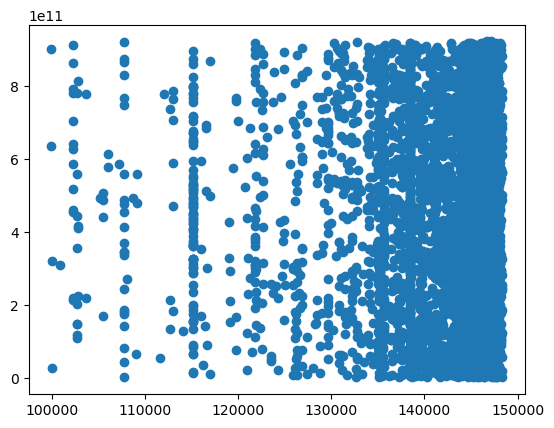

In [334]:
plt.scatter(plot_interactions.item_id, plot_interactions.user_id)